Before solving this notebook, make sure you have `Qiskit > 1.0` or higher and `Qiskit-ibm-runtime > 0.28` or higher installed. You must use `EstimatorV2` for your solution.

#### Creating the quantum circuit

### Coding with Qiskit 1

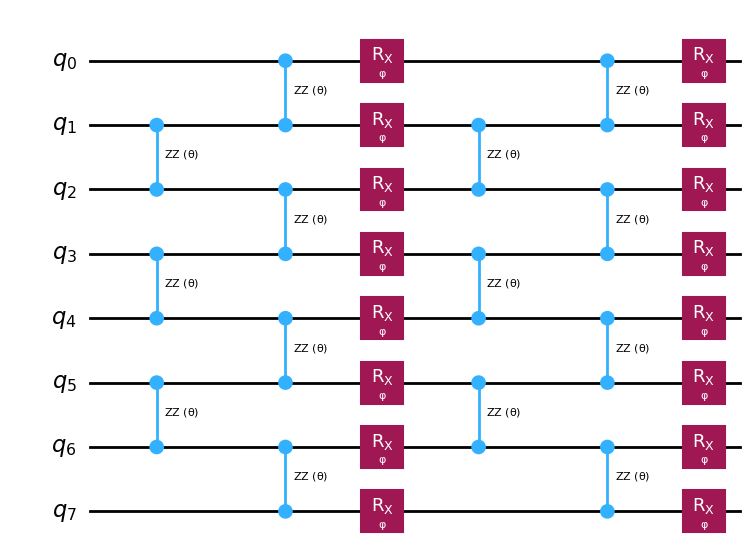

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')
phi = Parameter('φ')
num_qubits = 8
num_steps = 2

qc = QuantumCircuit(num_qubits)
for _ in range(num_steps):
    for i in range(1, num_qubits-1, 2):
        qc.rzz(theta, i, i+1)
    for i in range(0, num_qubits, 2):
        qc.rzz(theta, i, i+1)
    for i in range(num_qubits):
        qc.rx(phi, i)

qc.draw('mpl', fold=-1)

The goal of this exercise will be to calculate the ideal and noisy expectation values of the specified observables for a range of parameter values. In particular, both $\theta$ and $\phi$ will be varied between $0$ and $\pi$ in 5 equal intervals.

#### Q1. Generate parameters

In this step you need to generate 5 equal interval values between $[0,\pi]$ for each of $\theta$ and $\phi$. Create a copy of the circuit, assign a parameter of your choice, and draw the circuit.

Assigned θ = 1.57, φ = 2.36


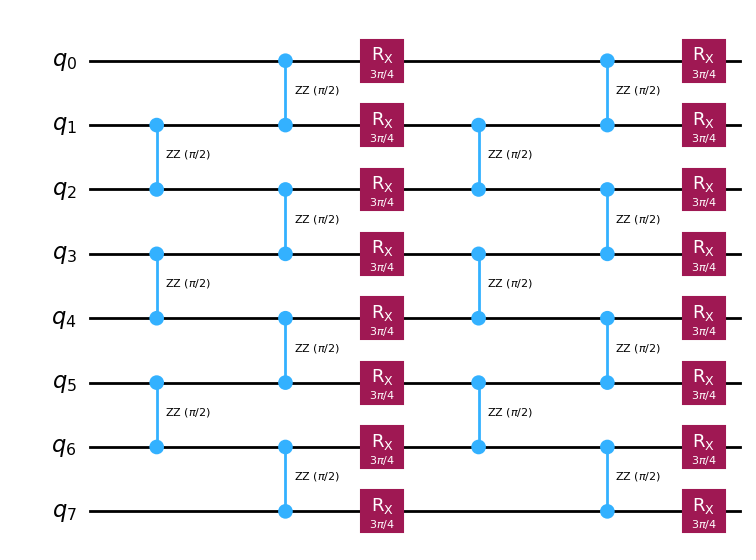

In [2]:
### Your solution here
# Define parameters
theta = Parameter('θ')
phi = Parameter('φ')
num_qubits = 8
num_steps = 2

# Create the original circuit
import numpy as np
qc = QuantumCircuit(num_qubits)
for _ in range(num_steps):
    for i in range(1, num_qubits-1, 2):
        qc.rzz(theta, i, i+1)
    for i in range(0, num_qubits-1, 2):  # Avoid last qubit error
        qc.rzz(theta, i, i+1)
    for i in range(num_qubits):
        qc.rx(phi, i)

# Generate 5 equal interval values for θ and φ
theta_values = np.linspace(0, np.pi, 5)
phi_values = np.linspace(0, np.pi, 5)

# Choose specific values for θ and φ
chosen_theta = theta_values[2]  # Middle value for θ
chosen_phi = phi_values[3]      # Fourth value for φ

# Create a copy of the circuit
qc_copy = qc.copy()

# Assign the parameters using assign_parameters
qc_copy = qc_copy.assign_parameters({theta: chosen_theta, phi: chosen_phi})

# Print the chosen parameters
print(f"Assigned θ = {chosen_theta:.2f}, φ = {chosen_phi:.2f}")

# Draw the copied circuit with assigned parameters
qc_copy.draw('mpl', fold=-1)


#### Q2. Transpile the circuit

In this step you will consider `FakeKolkataV2` as your `backend`. 

- Transpile the circuit on this backend.
- Print the different gates and their counts in the transpiled circuit.
- Print the layout (i.e., the physical qubits on which the circuit is placed) of the transpiled circuit.

In [14]:
pip install qiskit-ibm-runtime --upgrade  # Upgrade qiskit-ibm-runtime which includes the fake providers

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^



Gate counts in the transpiled circuit:
rz: 61
sx: 32
cx: 28

Layout of the transpiled circuit (logical -> physical qubits):
TranspileLayout(initial_layout=Layout({
25: Qubit(QuantumRegister(8, 'q'), 1),
24: Qubit(QuantumRegister(8, 'q'), 2),
26: Qubit(QuantumRegister(8, 'q'), 0),
23: Qubit(QuantumRegister(8, 'q'), 3),
21: Qubit(QuantumRegister(8, 'q'), 4),
18: Qubit(QuantumRegister(8, 'q'), 5),
15: Qubit(QuantumRegister(8, 'q'), 6),
12: Qubit(QuantumRegister(8, 'q'), 7),
0: Qubit(QuantumRegister(19, 'ancilla'), 0),
1: Qubit(QuantumRegister(19, 'ancilla'), 1),
2: Qubit(QuantumRegister(19, 'ancilla'), 2),
3: Qubit(QuantumRegister(19, 'ancilla'), 3),
4: Qubit(QuantumRegister(19, 'ancilla'), 4),
5: Qubit(QuantumRegister(19, 'ancilla'), 5),
6: Qubit(QuantumRegister(19, 'ancilla'), 6),
7: Qubit(QuantumRegister(19, 'ancilla'), 7),
8: Qubit(QuantumRegister(19, 'ancilla'), 8),
9: Qubit(QuantumRegister(19, 'ancilla'), 9),
10: Qubit(QuantumRegister(19, 'ancilla'), 10),
11: Qubit(QuantumRegister(

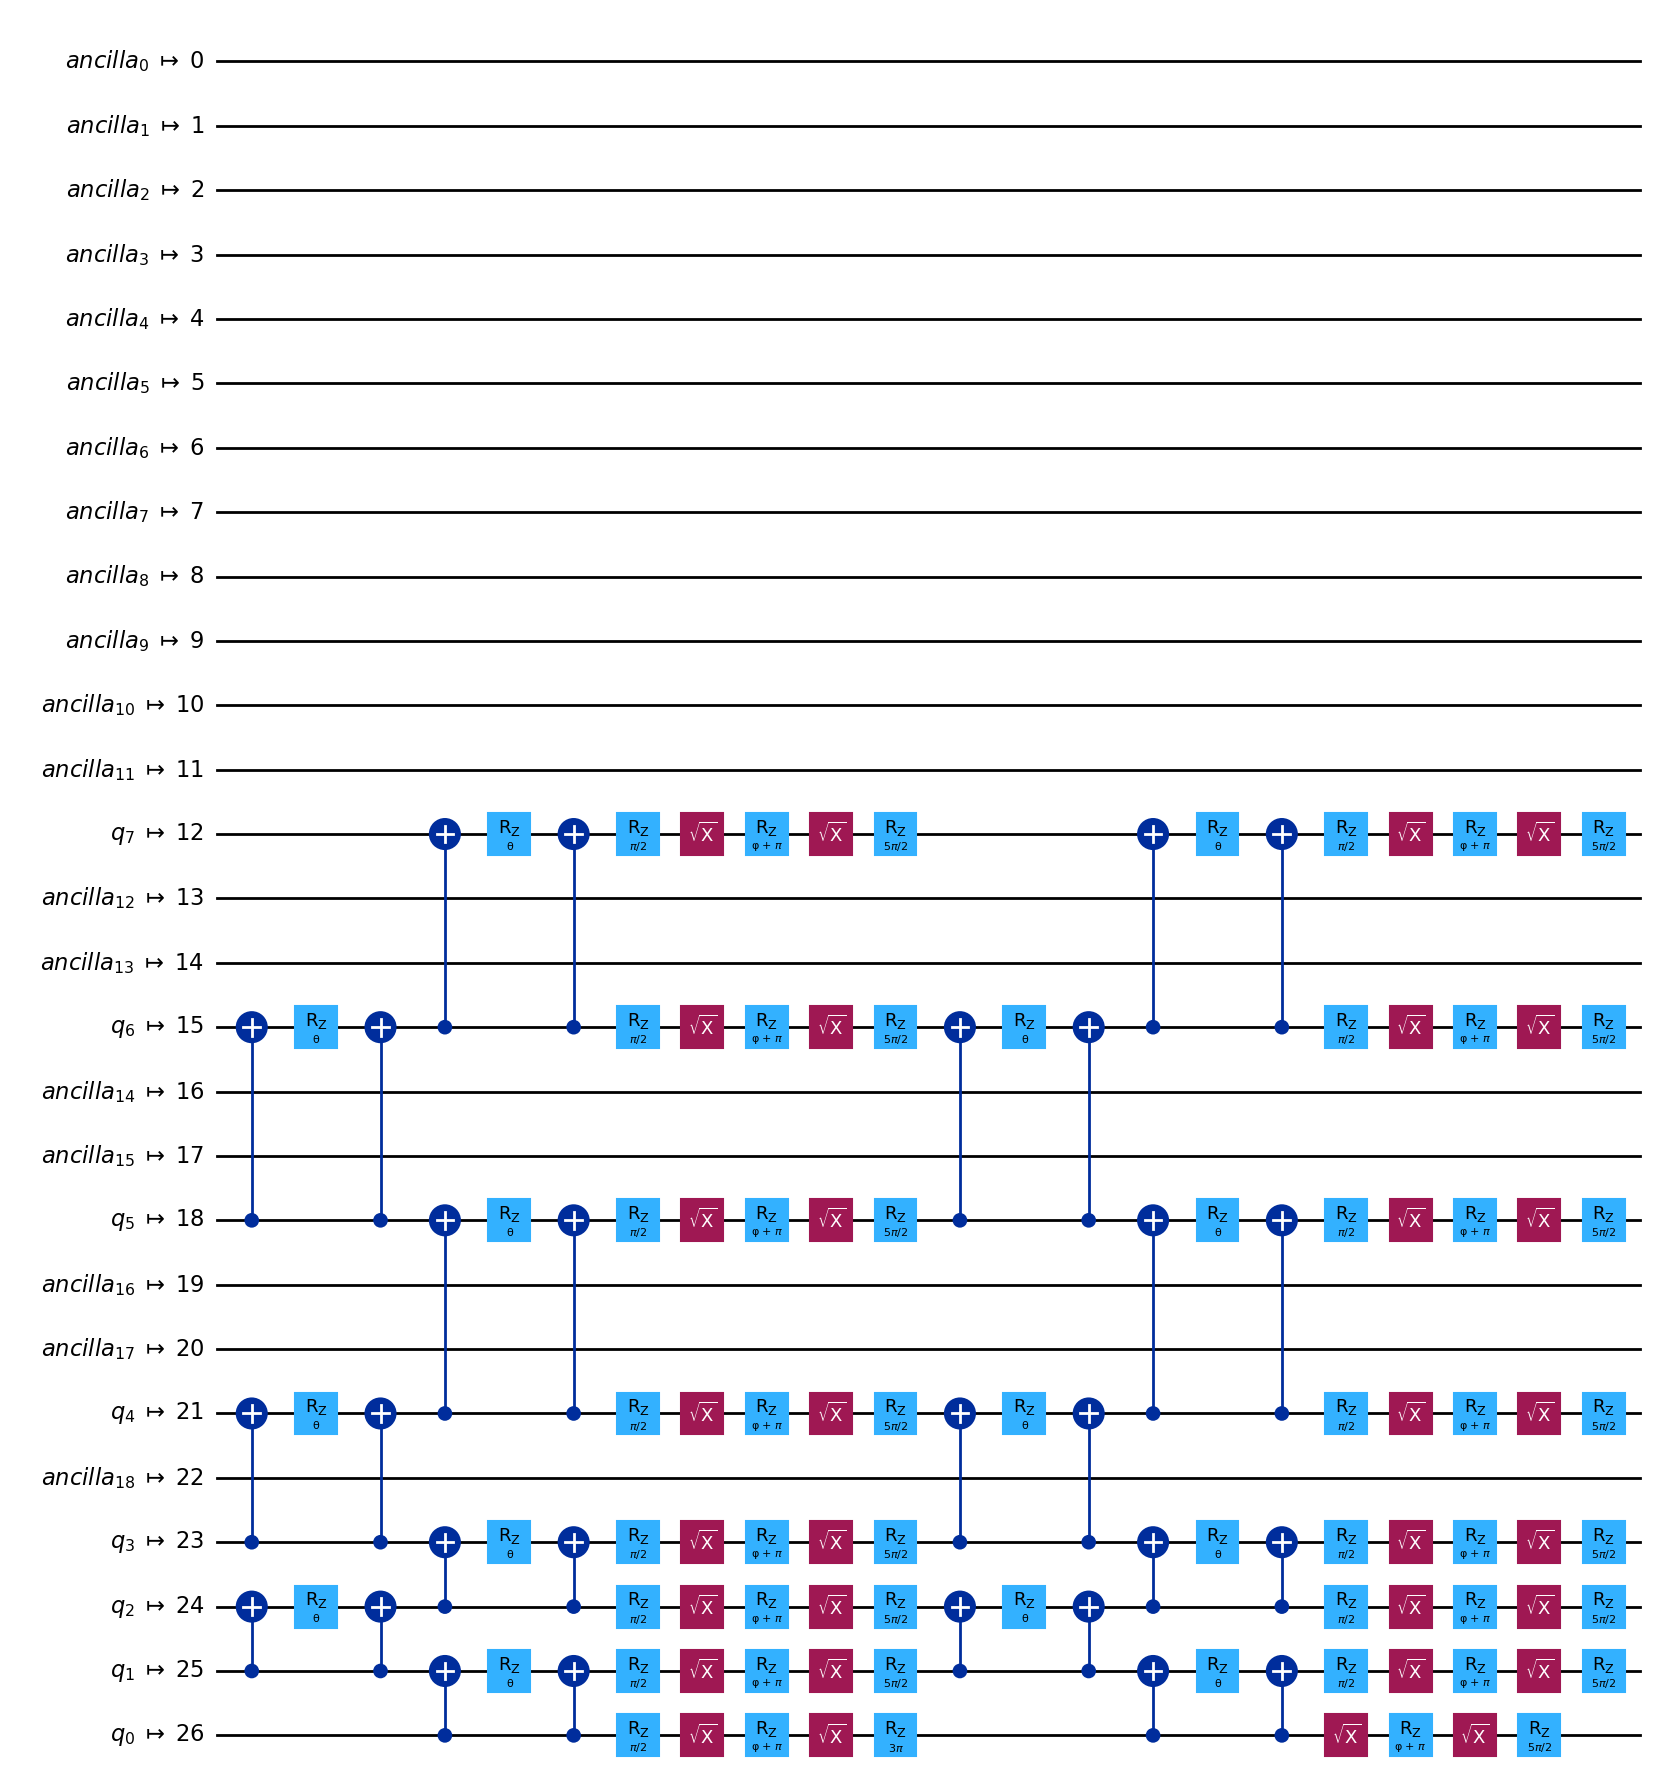

In [3]:
### Your solution here
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2 # Import FakeKolkataV2 from the updated path

#Load FakeKolkataV2 backend
backend = FakeKolkataV2()

#Transpile the circuit for the FakeKolkataV2 backend
optimization_level_answer = 3
pm = generate_preset_pass_manager(backend=backend,optimization_level=optimization_level_answer)
transpiled_qc = pm.run(qc)
#Print the gates and their counts in the transpiled circuit
print("\nGate counts in the transpiled circuit:")
gate_counts = transpiled_qc.count_ops()
for gate, count in gate_counts.items():
    print(f"{gate}: {count}")

#Print the layout (logical to physical qubit mapping)
print("\nLayout of the transpiled circuit (logical -> physical qubits):")
layout = transpiled_qc._layout
print(layout)

#Draw the transpiled circuit
print("\nTranspiled Circuit:")
transpiled_qc.draw('mpl', fold=-1)


#### Q3. Construct observable

In this step you will

- Construct the following observable: $\sum_{i=1}^{N}\langle Z_i \rangle / N$ where $N$ is the number of qubits.
- Apply the layout of the transpiled circuit to this observable. Print the observable after applying layout.

In [4]:
from qiskit.quantum_info import SparsePauliOp
# Define the observable (Pauli Z on each qubit normalized by N)
observable_terms = []
for i in range(num_qubits):
    # Generate Pauli string with 'Z' on qubit i and 'I' elsewhere
    pauli_string = ['I'] * num_qubits
    pauli_string[i] = 'Z'
    observable_terms.append(("".join(pauli_string), 1/num_qubits))

# Create SparsePauliOp observable
observable = SparsePauliOp.from_list(observable_terms)
print("\nOriginal Observable (Pauli Z terms normalized):")
print(observable)
hamiltonian_isa = observable.apply_layout(layout=transpiled_qc.layout)
print(hamiltonian_isa)


Original Observable (Pauli Z terms normalized):
SparsePauliOp(['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])


#### Q4. Prepare for execution

In this step you will create

- Primitive Unified Bloc (PUB) for each possible parameter combination (i.e., there will be $5\times5 = 25$ possible parameter combinations).

In [5]:
### Your solution here
theta_values = np.linspace(0, np.pi, 5)
phi_values = np.linspace(0, np.pi, 5)
parameter_grid = np.array(np.meshgrid(theta_values, phi_values)).T.reshape(-1, 2)
pub = (transpiled_qc, hamiltonian_isa, parameter_grid)

#### Q5. Noiseless execution

In this step you will

- Construct a `StatevectorEstimator`
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination; store the result

In [ ]:
from qiskit.primitives import StatevectorEstimator  
import matplotlib.pyplot as plt  
#Create the StatevectorEstimator instance
estimator = StatevectorEstimator()

#Run the estimator job
job = estimator.run([pub])
result = job.result()
evs_noiseless=result[0].data.evs
##stds=result[0].data.stds          #use for standard deviation


#### Q6. Noisy execution

In this step you will

- Construct an `EstimatorV2` object with `FakeKolkataV2` as the backend
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination
- In a single plot where X-axis is $\theta$ and Y-axis is $\Phi$, plot the outcomes of the noisy and noiseless expectation values

In [ ]:
### You Store results
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import EstimatorV2
estimator = EstimatorV2(backend)
#Calculate expectation values using Estimator
job = estimator.run([pub])
results = job.result()
evs_noisy=results[0].data.evs
#Print results
theta_grid, phi_grid = np.meshgrid(theta_values, phi_values)
# Reshape the expectation values to 2D for plotting (5x5 grid)
evs_noiseless_reshaped = np.array(evs_noiseless).reshape(len(phi_values), len(theta_values))
evs_noisy_reshaped = np.array(evs_noisy).reshape(len(phi_values), len(theta_values))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Noiseless expectation values
cax1 = axes[0].contourf(theta_grid, phi_grid, evs_noiseless_reshaped, cmap='viridis')
axes[0].set_title('Noiseless Expectation Values')
axes[0].set_xlabel('Theta (θ)')
axes[0].set_ylabel('Phi (φ)')
fig.colorbar(cax1, ax=axes[0], label='Expectation Value')

# Noisy expectation values
cax2 = axes[1].contourf(theta_grid, phi_grid, evs_noisy_reshaped, cmap='viridis')
axes[1].set_title('Noisy Expectation Values')
axes[1].set_xlabel('Theta (θ)')
axes[1].set_ylabel('Phi (φ)')
fig.colorbar(cax2, ax=axes[1], label='Expectation Value')

plt.tight_layout()
plt.show()

#### Q7. Building towards error mitigation

In this step you will create the framework for error mitigation. Obtaining error mitigated results in not possible on a noisy simulator. For this example, we want the following

- Apply Dynamical Decoupling with `XY4` pulse
- Apply Zero Noise Extrapolation with `[1,2,3]` as the noise factors and `exponential` extrapolator
- Turn on Gate Twirling
- Turn off Measurement Twirling
- Turn off Measurement Error Mitigation

Construct an `EstimatorV2` object with the previously stated error mitigation and suppression options.

In [ ]:
### Your solution here
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit import QuantumCircuit
from qiskit_aer import Aer

# Dynamical Decoupling with XY4
X = XGate()
Y = YGate()
dd_sequence = [X, Y, X, Y] #XY4
# Zero Noise Extrapolation settings
zne_factors = [1, 2, 3]
zne_extrapolator = 'exponential'  # Use exponential extrapolator

# Create EstimatorV2 configuration with required options as a dictionary
options = {
    "dynamical_decoupling": dd_sequence,
    "zero_noise_extrapolation": {
        "noise_factors": zne_factors,
        "extrapolator": zne_extrapolator,
    },
    "gate_twirling": True,  # Turn on gate twirling
    "measurement_twirling": False,  # Turn off measurement twirling
    "measurement_error_mitigation": False  # Turn off measurement error mitigation
}

# Create an EstimatorV2 object and apply the configuration
estimator_v2 = EstimatorV2(backend, options=options)